In [ ]:
# =============================================================
# MÓDULO 4 — Construcción del Dataset Final
# =============================================================
#
# Objetivo (misma finalidad que el código original):
#   Del CSV de incendios (históricos) → filtrado por zona/fechas/umbral → buffers
#   → variables satélite (Sentinel-2) + meteo (ERA5-Land) + topografía (SRTM)
#   → etiqueta (fire_label) → muestreo (sample) → exportación a CSV (Drive)
#
# IMPORTANTÍSIMO (para alumnos):
#   - Google Earth Engine (GEE) trabaja "en remoto": casi todo lo que creas
#     (ee.Image, ee.ImageCollection, ee.FeatureCollection...) NO vive en tu RAM,
#     vive como una "receta" (grafo) en los servidores de Google.
#   - La receta se ejecuta cuando pides resultados (por ejemplo con getInfo(),
#     exportaciones, o al visualizar en un mapa).
#
# =============================================================
# REQUISITOS/ENTORNO
# - Asumimos Google Colab o Jupyter
# - Añadimos visualizaciones y puntos de control (prints, counts, stats)
# - Añadimos robustez: checks de colecciones vacías, unidades, inicialización EE
# - Respetamos datasets del original:
#     * Sentinel-2: "COPERNICUS/S2_SR_HARMONIZED"
#     * ERA5-Land:  "ECMWF/ERA5_LAND/DAILY_AGGR"
#     * SRTM:       "USGS/SRTMGL1_003"
# =============================================================

# =============================================================
# A) IMPORTS + INSTALACIÓN OPCIONAL + UTILIDADES DE NOTEBOOK
# =============================================================

import os
import sys
import math
import warnings
from typing import Tuple, List, Optional

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geo stack
import geopandas as gpd
from shapely.geometry import Point

# Earth Engine
import ee

In [ ]:
# --------------------------------------------
# Instalación opcional (geemap y dependencias)
# --------------------------------------------
# Ojo:
# - En Colab suele funcionar instalar con pip.
# - En Jupyter local, necesitarás tener geemap + ipywidgets configurados.
#
# Si NO tienes geemap, descomenta la instalación automática:
#
#   !pip install -q geemap geopandas shapely
#
# Como estamos en Python "normal" (no notebook magic), hacemos instalación
# opcional con subprocess si falla el import.
try:
    import geemap
except ImportError:
    import subprocess
    print("⚠️ geemap no está instalado. Intentando instalarlo con pip...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "geemap"])
    import geemap

# Utilidad para display() (en notebooks queda más bonito)
try:
    from IPython.display import display
except Exception:
    display = print

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 110

In [ ]:
# =============================================================
# B) PARÁMETROS CONFIGURABLES (AOI, fechas, escala, CRS, etc.)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Define la "configuración" del experimento: años, umbrales, AOI, rutas...
#
# Cómo comprobar que va bien:
#   - Deberías ver un print con la zona elegida y el bbox.
#   - Si cambias CLAVE_AREA, debe existir dentro de AREAS.
#
# Errores típicos:
#   - KeyError si CLAVE_AREA no está en AREAS.
#   - BBOX mal definido (W>=E o S>=N).
# -----------------------------

MODO_DEBUG = True  # Si True: más prints, numPixels reducido, etc.

# Proyecto EE (el original lo usa así). Ojo: debes tener acceso a ese proyecto.
ID_PROYECTO_EE = "incendios-forestales-mvp"

UMBRAL_HA = 30                 # "Grandes incendios" >= 30 ha
ANIO_INI, ANIO_FIN = 2018, 2023  # filtro temporal en el CSV

# Zonas piloto (BBOX en EPSG:4326, formato [W,S,E,N])
AREAS = {
    "sierra_de_gata": {"nombre": "Sierra de Gata", "bbox": [-7.10, 39.95, -6.35, 40.65]},
    "el_bierzo":      {"nombre": "El Bierzo",      "bbox": [-6.95, 42.30, -6.10, 42.75]},
}

CLAVE_AREA = "el_bierzo"  # <-- cambia aquí si quieres otra zona
if CLAVE_AREA not in AREAS:
    raise KeyError(f"CLAVE_AREA='{CLAVE_AREA}' no existe. Opciones: {list(AREAS.keys())}")

bbox = AREAS[CLAVE_AREA]["bbox"]
print(f"📍 Área elegida: {AREAS[CLAVE_AREA]['nombre']}  |  BBOX (W,S,E,N): {bbox}")

# -----------------------------
# Rutas (original: estructura en Drive)
# -----------------------------
# En Colab, lo típico:
ruta_carpeta_proyecto_drive = "/content/drive/MyDrive/Piloto-Incendios"
ruta_csv_incendios_rel = "00-Datos-Crudos/incendios-1968-2023.csv"
carpeta_raiz_drive = "Piloto-Incendios"

# Salidas GeoJSON (manteniendo nombres del original)
ruta_geojson_puntos_rel = f"01-Datos-Procesados/incendios_big_{CLAVE_AREA}_puntos.geojson"
ruta_geojson_buffers_rel = f"01-Datos-Procesados/incendios_big_{CLAVE_AREA}_buffers.geojson"

# Fallback útil si NO estás en Drive (por ejemplo, si ejecutas en otro entorno):
# (no cambiamos dataset, solo el "path")
ruta_csv_incendios_fallback = "/mnt/data/incendios-1968-2023.csv"

📍 Área elegida: El Bierzo  |  BBOX (W,S,E,N): [-6.95, 42.3, -6.1, 42.75]


In [ ]:
# =============================================================
# C) INICIALIZACIÓN DE DRIVE (si aplica) + EARTH ENGINE (robusto)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Monta Drive (si estamos en Colab)
#   - Se mueve al directorio del proyecto
#   - Inicializa Earth Engine (con autenticación si hace falta)
#
# Conceptos EE (explicación didáctica):
#   ee.Initialize():
#     - Conecta tu notebook con Earth Engine.
#     - Si no estás autenticado, dará error.
#
# Mini-ejemplo:
#   try:
#       ee.Initialize()
#   except:
#       ee.Authenticate()
#       ee.Initialize()
#
# Cómo comprobar que va bien:
#   - Debe imprimirse: "✅ Earth Engine inicializado correctamente"
#   - Si falla, te abrirá un flujo de autenticación.
#
# Errores típicos:
#   - "Earth Engine client library not initialized"
#   - "Project not registered" (si el project ID no está habilitado para EE)
# -----------------------------

def estamos_en_colab() -> bool:
    return "google.colab" in sys.modules

def montar_drive_y_configurar_cwd() -> str:
    """
    Monta Google Drive en Colab y cambia el working directory a la carpeta del proyecto.
    Devuelve el path base del proyecto (cwd).
    """
    if not estamos_en_colab():
        print("ℹ️ No estás en Colab (o no detectado). Saltando montaje de Drive.")
        return os.getcwd()

    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")

    if not os.path.isdir(ruta_carpeta_proyecto_drive):
        raise FileNotFoundError(
            f"No existe la ruta del proyecto en Drive: {ruta_carpeta_proyecto_drive}\n"
            f"➡️ Revisa tu estructura de carpetas o cambia 'ruta_carpeta_proyecto_drive'."
        )

    os.chdir(ruta_carpeta_proyecto_drive)
    print("✅ Drive montado y directorio del proyecto configurado:", os.getcwd())
    return os.getcwd()

def inicializar_earth_engine(project_id: Optional[str] = None) -> None:
    """
    Inicializa Earth Engine con manejo de autenticación.
    """
    try:
        if project_id:
            ee.Initialize(project=project_id)
        else:
            ee.Initialize()
        print("✅ Earth Engine inicializado correctamente")
    except Exception as e:
        print("🔐 Necesitas autorizar Earth Engine. Abriendo autenticación...")
        print("   Detalle del error:", str(e)[:200], "...")
        ee.Authenticate()
        if project_id:
            ee.Initialize(project=project_id)
        else:
            ee.Initialize()
        print("✅ Earth Engine inicializado tras autenticar")

# Ejecutamos inicialización
_ = montar_drive_y_configurar_cwd()
print("🚀 Módulo 4: Construcción del Dataset Final")
print("======================================================")

inicializar_earth_engine(project_id=ID_PROYECTO_EE)

Mounted at /content/drive
✅ Drive montado y directorio del proyecto configurado: /content/drive/MyDrive/Piloto-Incendios
🚀 Módulo 4: Construcción del Dataset Final
🔐 Necesitas autorizar Earth Engine. Abriendo autenticación...
   Detalle del error: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry. ...
✅ Earth Engine inicializado tras autenticar


In [ ]:
# =============================================================
# D) CARGA Y PREPROCESADO DE DATOS TABULARES (CSV incendios)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Lee el CSV de incendios
#   - Parsea fechas
#   - Filtra por rango temporal (ANIO_INI..ANIO_FIN)
#   - Filtra "grandes incendios" por superficie >= UMBRAL_HA
#
# Cómo comprobar que va bien:
#   - Verás "Registros 2018-2023: X" y "Grandes incendios: Y"
#   - Si MODO_DEBUG=True, verás un head() y columnas disponibles.
#
# Errores típicos:
#   - Faltan columnas: 'fecha', 'superficie', 'lat', 'lng'
#   - Fecha mal parseada → NaT
# -----------------------------

def resolver_ruta_csv_incendios() -> str:
    """
    Resuelve la ruta del CSV en este entorno:
      1) Si estás en el proyecto de Drive: ruta relativa '00-Datos-Crudos/...'
      2) Si no existe: fallback '/mnt/data/incendios-1968-2023.csv'
    """
    # Caso Drive/proyecto
    posible = os.path.join(os.getcwd(), ruta_csv_incendios_rel)
    if os.path.isfile(posible):
        return posible

    # Caso fallback (por ejemplo, en un entorno donde el dataset está montado)
    if os.path.isfile(ruta_csv_incendios_fallback):
        return ruta_csv_incendios_fallback

    raise FileNotFoundError(
        "No encuentro el CSV de incendios.\n"
        f"- Probé: {posible}\n"
        f"- Probé fallback: {ruta_csv_incendios_fallback}\n"
        "➡️ Revisa rutas o monta Drive correctamente."
    )

def cargar_y_filtrar_incendios(ruta_csv: str, anio_ini: int, anio_fin: int, umbral_ha: float
                             ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Carga el CSV de incendios, parsea fecha y filtra:
      - rango temporal [anio_ini-01-01, anio_fin-12-31]
      - incendios grandes con superficie >= umbral_ha

    Devuelve:
      df_incendios_filtrado, df_incendios_grandes
    """
    df = pd.read_csv(ruta_csv)

    # Validaciones mínimas (robustez)
    for col in ["fecha", "superficie", "lat", "lng"]:
        if col not in df.columns:
            raise KeyError(f"Falta la columna '{col}' en el CSV. Columnas: {list(df.columns)[:30]} ...")

    # Parseo robusto de fecha
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

    # QA: ¿cuántas fechas han quedado como NaT?
    n_fechas_nulas = df["fecha"].isna().sum()
    if n_fechas_nulas > 0:
        print(f"⚠️ Fechas no parseadas (NaT): {n_fechas_nulas}. Revisa el formato de la columna 'fecha'.")

    # Filtro temporal
    fecha_ini = pd.to_datetime(f"{anio_ini}-01-01")
    fecha_fin = pd.to_datetime(f"{anio_fin}-12-31")
    df = df[(df["fecha"] >= fecha_ini) & (df["fecha"] <= fecha_fin)].copy()

    # Filtro "grandes incendios"
    df["superficie"] = pd.to_numeric(df["superficie"], errors="coerce")
    df_grandes = df[df["superficie"] >= float(umbral_ha)].copy()

    print(f"📄 Registros {anio_ini}-{anio_fin}: {len(df):,}")
    print(f"🔥 Grandes incendios (≥{umbral_ha} ha): {len(df_grandes):,}")
    return df, df_grandes

ruta_csv_incendios = resolver_ruta_csv_incendios()
print("📌 Usando CSV:", ruta_csv_incendios)

df_incendios, df_incendios_grandes = cargar_y_filtrar_incendios(
    ruta_csv=ruta_csv_incendios,
    anio_ini=ANIO_INI,
    anio_fin=ANIO_FIN,
    umbral_ha=UMBRAL_HA
)

if MODO_DEBUG:
    print("🧾 Columnas disponibles (primeras 25):", list(df_incendios.columns)[:25])
    display(df_incendios_grandes.head(3))

📌 Usando CSV: /content/drive/MyDrive/Piloto-Incendios/00-Datos-Crudos/incendios-1968-2023.csv
📄 Registros 2018-2023: 9,224
🔥 Grandes incendios (≥30 ha): 926
🧾 Columnas disponibles (primeras 25): ['id', 'superficie', 'fecha', 'lat', 'lng', 'latlng_explicit', 'idcomunidad', 'idprovincia', 'idmunicipio', 'municipio', 'causa', 'causa_supuesta', 'causa_desc', 'muertos', 'heridos', 'time_ctrl', 'time_ext', 'personal', 'medios', 'gastos', 'perdidas']


,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,...,causa_supuesta,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas
282964,2018460001,193.03,2018-01-04,39.623330,-0.276710,1.0,9,46,220,SAGUNT/SAGUNTO,...,0,99,0,0,1291,1901,99,8,0,0
283053,2018120009,118.68,2018-02-10,40.194958,0.200945,1.0,9,12,117,TORREBLANCA,...,0,99,0,0,1532,2672,79,11,0,0
283103,2018100103,47.67,2018-02-21,40.112824,-5.689041,1.0,14,10,14,ALDEANUEVA DE LA VERA,...,1,12,0,0,422,542,31,5,0,0


In [ ]:
# =============================================================
# E) FILTRADO POR BBOX + EXPORTAR PUNTOS A GEOJSON
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Filtra los incendios grandes dentro del bbox (W,S,E,N)
#   - Convierte a GeoDataFrame con geometría Point (EPSG:4326)
#   - Guarda GeoJSON (puntos)
#
# Conceptos (Geo):
#   - EPSG:4326 = lat/lon en grados (WGS84)
#   - BBOX = "caja" rectangular que recorta el mundo
#
# Cómo comprobar que va bien:
#   - Verás "Incendios grandes dentro del área: X"
#   - Se guardará el GeoJSON de puntos
#
# Errores típicos:
#   - lat/lon fuera de rango
#   - bbox mal definido (W<E y S<N)
# -----------------------------

def validar_bbox(bbox_wsen: List[float]) -> None:
    if len(bbox_wsen) != 4:
        raise ValueError("bbox debe tener 4 valores: [W,S,E,N]")
    W, S, E, N = bbox_wsen
    if not (-180 <= W <= 180 and -180 <= E <= 180):
        raise ValueError("Longitudes fuera de rango [-180, 180]")
    if not (-90 <= S <= 90 and -90 <= N <= 90):
        raise ValueError("Latitudes fuera de rango [-90, 90]")
    if not (W < E and S < N):
        raise ValueError("BBOX mal definido: debe cumplirse W < E y S < N")

def filtrar_incendios_por_bbox(df_grandes: pd.DataFrame, bbox_wsen: List[float]) -> pd.DataFrame:
    """
    Filtra incendios por BBOX en EPSG:4326.
    bbox = [W,S,E,N]
    """
    validar_bbox(bbox_wsen)
    W, S, E, N = bbox_wsen

    df_area = df_grandes[
        (df_grandes["lng"] >= W) & (df_grandes["lng"] <= E) &
        (df_grandes["lat"] >= S) & (df_grandes["lat"] <= N)
    ].copy()

    print(f"🔥 Incendios grandes dentro del área ({AREAS[CLAVE_AREA]['nombre']}): {len(df_area):,}")
    return df_area

def asegurar_directorio_para_archivo(path: str) -> None:
    """
    Crea el directorio padre si no existe (para guardar GeoJSON/CSVs...).
    """
    carpeta = os.path.dirname(path)
    if carpeta and not os.path.isdir(carpeta):
        os.makedirs(carpeta, exist_ok=True)

def dataframe_a_geojson_puntos(df_area: pd.DataFrame, ruta_salida: str) -> gpd.GeoDataFrame:
    """
    Convierte df (con lat/lng) a GeoDataFrame EPSG:4326 y lo guarda a GeoJSON.
    """
    asegurar_directorio_para_archivo(ruta_salida)

    # Crear geometría Point (x=lng, y=lat)
    gdf = gpd.GeoDataFrame(
        df_area.copy(),
        geometry=[Point(xy) for xy in zip(df_area["lng"], df_area["lat"])],
        crs="EPSG:4326"
    )

    gdf.to_file(ruta_salida, driver="GeoJSON")
    print("✅ Guardado GeoJSON (puntos):", ruta_salida)
    return gdf

# Rutas absolutas (desde cwd actual)
ruta_geojson_puntos = os.path.join(os.getcwd(), ruta_geojson_puntos_rel)
ruta_geojson_buffers = os.path.join(os.getcwd(), ruta_geojson_buffers_rel)

df_incendios_area = filtrar_incendios_por_bbox(df_incendios_grandes, bbox)

if MODO_DEBUG and len(df_incendios_area) > 0:
    cols_preview = [c for c in ["id", "fecha", "superficie", "lat", "lng", "municipio"] if c in df_incendios_area.columns]
    display(df_incendios_area[cols_preview].head(5))

gdf_puntos_incendio = dataframe_a_geojson_puntos(df_incendios_area, ruta_geojson_puntos)

if MODO_DEBUG and len(gdf_puntos_incendio) > 0:
    display(gdf_puntos_incendio.head(5))

🔥 Incendios grandes dentro del área (El Bierzo): 12


,id,fecha,superficie,lat,lng,municipio
283195,2018240029,2018-02-26,55.00,42.675637,-6.833633,TRABADELO
285813,2019240073,2019-02-26,120.97,42.346804,-6.720458,BENUZA
286861,2019240182,2019-03-29,95.28,42.331610,-6.681844,BENUZA
288564,2019240423,2019-10-03,35.73,42.493682,-6.606800,PONFERRADA
288736,2019240446,2019-12-29,88.24,42.305971,-6.729525,ENCINEDO


✅ Guardado GeoJSON (puntos): /content/drive/MyDrive/Piloto-Incendios/01-Datos-Procesados/incendios_big_el_bierzo_puntos.geojson


,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,...,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas,geometry
283195,2018240029,55.00,2018-02-26,42.675637,-6.833633,1.0,17,24,171,TRABADELO,...,24,0,0,1606,1606,5,0,0,0,POINT (-6.83363 42.67564)
285813,2019240073,120.97,2019-02-26,42.346804,-6.720458,1.0,17,24,16,BENUZA,...,3,0,0,1209,1711,7,1,0,0,POINT (-6.72046 42.3468)
286861,2019240182,95.28,2019-03-29,42.331610,-6.681844,1.0,17,24,16,BENUZA,...,25,0,0,1302,1385,27,8,0,0,POINT (-6.68184 42.33161)
288564,2019240423,35.73,2019-10-03,42.493682,-6.606800,1.0,17,24,115,PONFERRADA,...,14,0,0,302,1532,98,19,0,0,POINT (-6.6068 42.49368)
288736,2019240446,88.24,2019-12-29,42.305971,-6.729525,1.0,17,24,67,ENCINEDO,...,19,0,0,0,460,0,0,0,0,POINT (-6.72952 42.30597)


✅ Buffers (perímetros aproximados) guardados: /content/drive/MyDrive/Piloto-Incendios/01-Datos-Procesados/incendios_big_el_bierzo_buffers.geojson


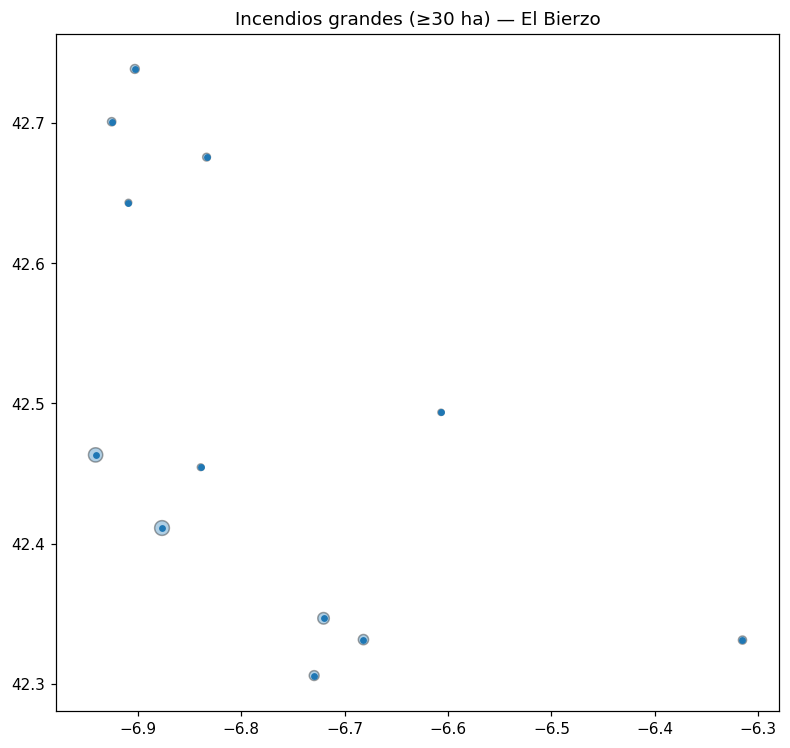

,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,...,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas,geometry
283195,2018240029,55.00,2018-02-26,42.675637,-6.833633,1.0,17,24,171,TRABADELO,...,24,0,0,1606,1606,5,0,0,0,"POLYGON ((-6.82987 42.67564, -6.82989 42.67537..."
285813,2019240073,120.97,2019-02-26,42.346804,-6.720458,1.0,17,24,16,BENUZA,...,3,0,0,1209,1711,7,1,0,0,"POLYGON ((-6.71488 42.3468, -6.71491 42.3464, ..."
286861,2019240182,95.28,2019-03-29,42.331610,-6.681844,1.0,17,24,16,BENUZA,...,25,0,0,1302,1385,27,8,0,0,"POLYGON ((-6.6769 42.33161, -6.67692 42.33125,..."
288564,2019240423,35.73,2019-10-03,42.493682,-6.606800,1.0,17,24,115,PONFERRADA,...,14,0,0,302,1532,98,19,0,0,"POLYGON ((-6.60377 42.49368, -6.60378 42.49346..."
288736,2019240446,88.24,2019-12-29,42.305971,-6.729525,1.0,17,24,67,ENCINEDO,...,19,0,0,0,460,0,0,0,0,"POLYGON ((-6.72476 42.30597, -6.72479 42.30563..."


In [ ]:
# =============================================================
# F) CREAR BUFFERS (PERÍMETROS APROXIMADOS) Y GUARDAR GEOJSON
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Aproxima perímetros de incendios como círculos a partir de superficie (ha)
#   - Convierte ha → m² y calcula radio r = sqrt(area/pi)
#   - Genera buffers en un CRS métrico (EPSG:3857) para que "metros" sean metros
#   - Vuelve a EPSG:4326 y guarda GeoJSON (polígonos)
#
# Conceptos (CRS):
#   - Un CRS define "cómo se mapean" coordenadas a la Tierra
#   - EPSG:4326 usa grados (no sirve para medir distancias en metros)
#   - Para buffer en metros necesitamos un CRS métrico (ej: UTM o 3857)
#
# Mini-ejemplo:
#   gdf_utm = gdf.to_crs("EPSG:25830")  # UTM 30N (España)
#   gdf_utm["geometry"] = gdf_utm.buffer(500)  # 500 metros
#   gdf_wgs = gdf_utm.to_crs("EPSG:4326")
#
# Cómo comprobar que va bien:
#   - Se guardará GeoJSON buffers
#   - Se visualizará un plot rápido con puntos + polígonos
#
# Errores típicos:
#   - superficies <= 0
#   - reproyección falla por CRS inválido
# -----------------------------

def crear_buffers_circulares_desde_superficie(
    gdf_puntos_wgs84: gpd.GeoDataFrame,
    columna_superficie_ha: str = "superficie",
    crs_metrico: str = "EPSG:3857",
    ruta_salida: Optional[str] = None
) -> gpd.GeoDataFrame:
    """
    Crea polígonos 'buffer' circulares aproximando el perímetro del incendio.
    Suposición: superficie está en hectáreas (ha).

    Fórmula:
      area_m2 = ha * 10,000
      r = sqrt(area_m2 / pi)

    Devuelve:
      gdf_buffers en EPSG:4326
    """
    if columna_superficie_ha not in gdf_puntos_wgs84.columns:
        raise KeyError(f"Falta '{columna_superficie_ha}' en el GeoDataFrame. Columnas: {gdf_puntos_wgs84.columns.tolist()}")

    # Reproyectar a CRS métrico para que buffer(r) interprete r como metros.
    gdf_metricas = gdf_puntos_wgs84.to_crs(crs_metrico)

    # Convertir ha → m²
    area_m2 = pd.to_numeric(gdf_metricas[columna_superficie_ha], errors="coerce") * 10000.0

    # QA: superficies negativas o cero
    if (area_m2 <= 0).any():
        print("⚠️ Hay superficies <= 0. Es probable que haya datos erróneos en 'superficie'.")

    # Calcular radio en metros
    radio_m = np.sqrt(area_m2 / math.pi)

    # Crear buffers (círculos aproximados)
    gdf_metricas = gdf_metricas.copy()
    gdf_metricas["geometry"] = gdf_metricas.geometry.buffer(radio_m)

    # Volver a WGS84
    gdf_buffers = gdf_metricas.to_crs("EPSG:4326")

    # Guardar si se pide
    if ruta_salida:
        asegurar_directorio_para_archivo(ruta_salida)
        gdf_buffers.to_file(ruta_salida, driver="GeoJSON")
        print("✅ Buffers (perímetros aproximados) guardados:", ruta_salida)

    return gdf_buffers

gdf_buffers_incendio = crear_buffers_circulares_desde_superficie(
    gdf_puntos_wgs84=gdf_puntos_incendio,
    columna_superficie_ha="superficie",
    crs_metrico="EPSG:3857",  # MVP (aprox). Mejor UTM local en proyectos serios.
    ruta_salida=ruta_geojson_buffers
)

# Visualización rápida (GeoPandas + Matplotlib)
if MODO_DEBUG and len(gdf_buffers_incendio) > 0:
    ax = gdf_buffers_incendio.plot(alpha=0.35, edgecolor="black")
    gdf_puntos_incendio.plot(ax=ax, markersize=12)
    plt.title(f"Incendios grandes (≥{UMBRAL_HA} ha) — {AREAS[CLAVE_AREA]['nombre']}")
    plt.show()
    display(gdf_buffers_incendio.head(5))
else:
    print("ℹ️ No hay buffers para visualizar (¿0 incendios en la zona?).")

In [ ]:
# =============================================================
# G) EARTH ENGINE — CREAR GEOMETRÍA DE LA ZONA (ee.Geometry)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Convierte bbox a ee.Geometry.Rectangle
#
# Conceptos GEE:
#   - ee.Geometry: geometría (punto/rectángulo/polígono) usada para recortar,
#     filtrar colecciones, calcular estadísticas...
#
# Mini-ejemplo (pseudocódigo):
#   zona = ee.Geometry.Point([lon, lat]).buffer(1000)
#   img = ee.Image("...").clip(zona)
#
# Cómo comprobar que va bien:
#   - Podemos visualizar la AOI en un mapa (geemap).
# -----------------------------

def ee_rectangulo_desde_bbox(bbox_wsen: List[float]) -> ee.Geometry:
    """Crea ee.Geometry.Rectangle a partir de bbox [W,S,E,N]."""
    validar_bbox(bbox_wsen)
    W, S, E, N = bbox_wsen
    return ee.Geometry.Rectangle([W, S, E, N])

zona_ee = ee_rectangulo_desde_bbox(bbox)

In [ ]:
# =============================================================
# H) SENTINEL-2 — COMPOSITE ESTIVAL + ÍNDICES (NDVI/NDWI/NBR)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Carga ImageCollection de Sentinel-2 SR (harmonized)
#   - Filtra por:
#       * filterBounds(zona)  -> solo imágenes que intersectan la zona
#       * filterDate(...)     -> solo fechas de verano
#       * filter(...)         -> nubes por metadato (CLOUDY_PIXEL_PERCENTAGE)
#   - map() para añadir bandas NDVI, NDWI, NBR a cada imagen
#   - reduce temporal (median) para crear un "composite" estival
#
# Conceptos GEE (OBLIGATORIOS):
#
# 1) ee.Image vs ee.ImageCollection
#   - ee.Image: una imagen (como una "foto" con bandas)
#   - ee.ImageCollection: muchas imágenes (una serie temporal)
#
#   Mini-ejemplo:
#     img = ee.Image("USGS/SRTMGL1_003")  # una imagen
#     ic = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")  # colección
#
# 2) filterDate / filterBounds / map
#   - filterDate("2020-06-01","2020-09-30") -> recorta por fechas
#   - filterBounds(geometry) -> recorta por intersección espacial
#   - map(func) -> aplica una función a cada imagen de la colección
#
#   Mini-ejemplo:
#     ic_verano = ic.filterBounds(zona).filterDate("2020-06-01","2020-09-30")
#     ic_ndvi = ic_verano.map(lambda img: img.addBands(img.normalizedDifference(["B8","B4"]).rename("NDVI")))
#
# 3) Reducers (mean, max, min, median)
#   - Un reducer "resume" muchos valores en uno solo.
#   - Aquí usamos median() sobre la colección: es un reducer temporal.
#
# 4) Bandas e índices
#   - NDVI = (NIR - RED) / (NIR + RED)
#   - NDWI = (NIR - SWIR1) / (NIR + SWIR1)
#   - NBR  = (NIR - SWIR2) / (NIR + SWIR2)
#
# Cómo comprobar que va bien:
#   - Ver size() de la colección tras filtros (debería ser > 0)
#   - Ver rangos típicos NDVI/NDWI/NBR dentro de zona (reduceRegion min/max)
#
# Errores típicos:
#   - Colección vacía -> zona pequeña o nubes muy estrictas
#   - Bandas mal nombradas
# -----------------------------

def _check_imagecollection_nonempty(ic: ee.ImageCollection, nombre: str) -> None:
    """Lanza error didáctico si una ImageCollection está vacía tras filtros."""
    n = ic.size().getInfo()  # fuerza evaluación (server → client)
    print(f"🔎 {nombre}.size() = {n}")
    if n == 0:
        raise ValueError(
            f"La colección '{nombre}' está vacía tras filtros.\n"
            f"➡️ Prueba a: (1) ampliar bbox, (2) relajar cloud_pct, (3) revisar fechas."
        )

def crear_composite_sentinel2_verano(
    anio: int,
    zona: ee.Geometry,
    cloud_pct: int = 20,
    aplicar_mask_nubes_pixel: bool = False
) -> ee.Image:
    """
    Crea un composite de verano (junio-septiembre) con índices:
      - ndvi_verano
      - ndwi_verano
      - nbr_verano

    NOTA importante (teledetección):
      - Sentinel-2 tiene bandas a distintas resoluciones (10m, 20m, 60m).
      - B8 (NIR) es 10m; B11/B12 (SWIR) son 20m.
      - Earth Engine re-muestrea internamente al combinar bandas.
      - En versiones avanzadas, podrías fijar proyección/scale para consistencia.
    """
    fecha_ini = f"{anio}-06-01"
    fecha_fin = f"{anio}-09-30"

    coleccion_s2 = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(zona)
        .filterDate(fecha_ini, fecha_fin)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))
    )

    _check_imagecollection_nonempty(coleccion_s2, f"S2_SR_HARMONIZED_{anio}_verano")

    # Ejemplo mini (comentario):
    #   def f(img):
    #       ndvi = img.normalizedDifference(["B8","B4"]).rename("NDVI")
    #       return img.addBands(ndvi)
    #   ic = ic.map(f)

    def mask_s2_clouds_scl(img: ee.Image) -> ee.Image:
        """
        EJEMPLO DIDÁCTICO: máscara de nubes pixel-a-pixel usando SCL (Scene Classification Layer).
        se activa solo si aplicar_mask_nubes_pixel=True.

        Concepto: updateMask()
          - Una máscara en EE es un "0/1" por píxel:
              1 = píxel válido
              0 = píxel inválido (se ignora en cálculos)
          - updateMask(mascara) aplica esa máscara.

        Mini-ejemplo (pseudocódigo):
          mascara = img.select("QA60").eq(0)
          img_limpia = img.updateMask(mascara)
        """
        scl = img.select("SCL")
        # Clases típicas a enmascarar (dependen de doc SCL):
        # 3 = cloud shadow, 8/9/10 = clouds, 11 = snow/ice
        mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
        return img.updateMask(mask)

    def _agregar_indices(img: ee.Image) -> ee.Image:
        if aplicar_mask_nubes_pixel:
            img = mask_s2_clouds_scl(img)

        ndvi = img.normalizedDifference(["B8", "B4"]).rename("ndvi_verano")
        ndwi = img.normalizedDifference(["B8", "B11"]).rename("ndwi_verano")
        nbr  = img.normalizedDifference(["B8", "B12"]).rename("nbr_verano")
        return img.addBands([ndvi, ndwi, nbr])

    coleccion_con_indices = coleccion_s2.map(_agregar_indices)

    # Reducer temporal: mediana (robusta a outliers)
    composite = coleccion_con_indices.select(["ndvi_verano", "ndwi_verano", "nbr_verano"]).median()

    return composite.clip(zona)

In [ ]:
# =============================================================
# I) ERA5-Land — FEATURES METEO (tmax, precip, viento, depresión rocío)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Carga ImageCollection ERA5-Land DAILY_AGGR (verano)
#   - Calcula:
#       1) tmax_verano_c (Kelvin → ºC)
#       2) precip_verano_mm (metros → mm)
#       3) viento10m_verano_max_ms (sqrt(u^2+v^2))
#       4) depresion_rocio_verano_c (Tmean - Tdmean)
#
# Conceptos:
#   - Unidades importan muchísimo:
#       * Temperatura en ERA5 suele venir en Kelvin
#       * Precipitación en ERA5 suele venir en metros (de agua)
#   - Reducers:
#       * max(), mean(), sum() aplicados sobre ImageCollection producen ee.Image
#         (una "imagen resumen" del periodo)
#
# Mini-ejemplo:
#   ic = ee.ImageCollection("...").filterDate(...)
#   img_max = ic.select("temp").max()      # ee.Image
#   img_sum = ic.select("precip").sum()    # ee.Image
#
# Cómo comprobar que va bien:
#   - Imprimir min/max de cada banda con reduceRegion dentro de zona
#
# Errores típicos:
#   - Banda no existe -> revisar bandNames() de la colección
# -----------------------------

def extraer_features_era5_verano(anio: int, zona: ee.Geometry) -> ee.Image:
    """
    Extrae features meteorológicas (junio-septiembre) de ERA5-Land DAILY_AGGR.
    """
    fecha_ini = f"{anio}-06-01"
    fecha_fin = f"{anio}-09-30"

    coleccion_era5 = (
        ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
        .filterBounds(zona)
        .filterDate(fecha_ini, fecha_fin)
    )

    _check_imagecollection_nonempty(coleccion_era5, f"ERA5_LAND_DAILY_AGGR_{anio}_verano")

    # (Checkpoint didáctico) Ver bandas disponibles en la primera imagen del periodo
    if MODO_DEBUG:
        bandas = coleccion_era5.first().bandNames().getInfo()
        print("🧠 Bandas ERA5 (primera imagen del filtro):", bandas)

    # 1) Tmax del periodo (ºC)
    tmax_c = (
        coleccion_era5.select("temperature_2m_max")
        .max()
        .subtract(273.15)
        .rename("tmax_verano_c")
    )

    # 2) Precipitación total (mm)
    precip_mm = (
        coleccion_era5.select("total_precipitation_sum")
        .sum()
        .multiply(1000)
        .rename("precip_verano_mm")
    )

    # 3) Viento máximo 10m (m/s)
    # Ojo alumno: u/v son colecciones -> primero reducimos a ee.Image con max()
    u_max = coleccion_era5.select("u_component_of_wind_10m").max()
    v_max = coleccion_era5.select("v_component_of_wind_10m").max()

    # sqrt(u^2 + v^2)
    viento_max = (
        u_max.pow(2).add(v_max.pow(2)).sqrt()
        .rename("viento10m_verano_max_ms")
    )

    # 4) Depresión del punto de rocío (ºC): (Tmean - Tdmean)
    tmean_c  = coleccion_era5.select("temperature_2m").mean().subtract(273.15)
    tdmean_c = coleccion_era5.select("dewpoint_temperature_2m").mean().subtract(273.15)
    depresion_rocio = tmean_c.subtract(tdmean_c).rename("depresion_rocio_verano_c")

    return ee.Image.cat([tmax_c, precip_mm, viento_max, depresion_rocio]).clip(zona)


In [ ]:
# =============================================================
# J) TOPOGRAFÍA — SRTM (elevación, pendiente, aspecto)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Carga SRTM (una ee.Image)
#   - Calcula derivados con ee.Terrain.products (slope, aspect, etc.)
#
# Conceptos:
#   - Topografía es "estática" (no cambia por año)
#
# Mini-ejemplo:
#   srtm = ee.Image("USGS/SRTMGL1_003")
#   terrain = ee.Terrain.products(srtm)
#   slope = terrain.select("slope")
#
# Cómo comprobar que va bien:
#   - Visualizar elevación/slope en mapa
#   - reduceRegion min/max dentro de la zona
# -----------------------------

def crear_topografia_srtm(zona: ee.Geometry) -> ee.Image:
    """
    Crea features topográficas desde SRTM:
      - elev_m
      - pendiente_deg
      - aspecto_deg
    """
    srtm = ee.Image("USGS/SRTMGL1_003")
    terrain = ee.Terrain.products(srtm)

    elev = srtm.select("elevation").rename("elev_m")
    slope = terrain.select("slope").rename("pendiente_deg")
    aspect = terrain.select("aspect").rename("aspecto_deg")

    return ee.Image.cat([elev, slope, aspect]).clip(zona)

img_topografia = crear_topografia_srtm(zona_ee)

In [ ]:
# =============================================================
# K) INCENDIOS (BUFFERS) → EE FeatureCollection
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Lee el GeoJSON de buffers
#   - Añade columna "year" a partir de la fecha
#   - Convierte GeoDataFrame → ee.FeatureCollection (con geemap.gdf_to_ee)
#
# Conceptos GEE:
#   Feature vs FeatureCollection:
#     - ee.Feature = una geometría + propiedades (como una fila con un polígono)
#     - ee.FeatureCollection = muchas Features (como una tabla espacial)
#
# Mini-ejemplo:
#   f = ee.Feature(ee.Geometry.Point([-3,40]), {"id": 1})
#   fc = ee.FeatureCollection([f])
#
# Cómo comprobar que va bien:
#   - fc.size().getInfo() debe ser > 0 (si había incendios)
#   - Visualizar los polígonos en un mapa
#
# Errores típicos:
#   - year no existe o queda NaN
#   - GeoJSON no se guardó / ruta incorrecta
# -----------------------------

def geojson_buffers_a_featurecollection_ee(ruta_geojson_buffers: str) -> ee.FeatureCollection:
    if not os.path.isfile(ruta_geojson_buffers):
        raise FileNotFoundError(f"No existe el GeoJSON de buffers: {ruta_geojson_buffers}")

    gdf = gpd.read_file(ruta_geojson_buffers)

    # Crear columna 'year' desde 'fecha'
    if "fecha" not in gdf.columns:
        raise KeyError(f"El GeoJSON no tiene columna 'fecha'. Columnas: {gdf.columns.tolist()}")

    gdf["year"] = pd.to_datetime(gdf["fecha"], errors="coerce").dt.year

    # QA: años nulos
    n_year_null = gdf["year"].isna().sum()
    if n_year_null > 0:
        print(f"⚠️ year nulo en {n_year_null} filas. Revisa columna 'fecha'.")

    # Convertir a int si se puede (evita problemas de filtro)
    # Ojo: si hay NaN no se puede convertir directamente, por eso usamos Int64 nullable
    gdf["year"] = gdf["year"].astype("Int64")

    # Convertir a FeatureCollection EE
    fc = geemap.gdf_to_ee(gdf)
    print("✅ Buffers convertidos a ee.FeatureCollection")
    print("   Total features (buffers):", fc.size().getInfo())
    return fc

fc_incendios_ee = geojson_buffers_a_featurecollection_ee(ruta_geojson_buffers)

✅ Buffers convertidos a ee.FeatureCollection
   Total features (buffers): 12


In [ ]:
# =============================================================
# L) CREAR IMAGEN DE ETIQUETA (fire_label) POR AÑO
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Para un año dado:
#       * filtra los buffers (FeatureCollection) por year
#       * "pinta" esos polígonos sobre una imagen base 0 → 1 donde hay incendio
#
# Conceptos GEE:
#   - paint():
#       convierte vector → raster (imagen)
#   - clip(zona):
#       recorta la imagen a la zona
#
# Mini-ejemplo:
#   img0 = ee.Image(0)
#   img_label = img0.paint(fc, 1).rename("label")
#
# Cómo comprobar que va bien:
#   - Visualizar fire_label en el mapa
#   - Contar área etiquetada (reduceRegion sum) a una escala determinada
# -----------------------------

def crear_imagen_etiqueta_incendio(anio: int, zona: ee.Geometry, fc_incendios: ee.FeatureCollection) -> ee.Image:
    fc_anio = fc_incendios.filter(ee.Filter.eq("year", anio))
    # Imagen base (0) en tipo byte (0-255). Luego pintamos 1 donde hay polígono.
    etiqueta = ee.Image(0).byte().paint(fc_anio, 1).rename("fire_label")
    return etiqueta.clip(zona)

In [ ]:
# =============================================================
# M) CREAR IMAGEN DE FEATURES POR AÑO (S2 + ERA5 + TOPO)
# =============================================================

def crear_imagen_features(anio: int, zona: ee.Geometry) -> ee.Image:
    """
    Concatena todas las features:
      - Sentinel-2 (índices) + ERA5 (meteo) + topografía
    """
    img_s2 = crear_composite_sentinel2_verano(anio, zona, cloud_pct=20, aplicar_mask_nubes_pixel=False)
    img_era5 = extraer_features_era5_verano(anio, zona)
    img = ee.Image.cat([img_s2, img_era5, img_topografia]).clip(zona)
    return img

In [ ]:
# =============================================================
# N) CHECKPOINTS (reduceRegion) PARA VER SI LOS RANGOS TIENEN SENTIDO
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Calcula min/max/mean de bandas clave dentro de la zona con reduceRegion
#
# Conceptos:
#   reduceRegion:
#     - Reduce (resume) una imagen sobre una geometría → diccionario de resultados
#
#   Mini-ejemplo:
#     stats = img.select("ndvi").reduceRegion(
#         reducer=ee.Reducer.minMax(),
#         geometry=zona,
#         scale=250
#     )
#
# reduceRegions:
#   - Similar, pero sobre MUCHAS geometrías (FeatureCollection)
#   - Devuelve un FeatureCollection con stats por feature
#
# Cómo comprobar que va bien:
#   - NDVI/NDWI/NBR típicamente en [-1, 1]
#   - tmax_verano_c ~ 0..50 (depende)
#   - precip_verano_mm ~ 0..600 (depende)
#   - pendiente_deg ~ 0..90
# -----------------------------

def stats_minmax_mean(img: ee.Image, zona: ee.Geometry, scale: int, band_names: List[str], etiqueta: str) -> None:
    """
    Imprime stats min/max/mean por banda usando reduceRegion.
    """
    reducer = ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True)
    stats = img.select(band_names).reduceRegion(
        reducer=reducer,
        geometry=zona,
        scale=scale,
        maxPixels=1e9
    ).getInfo()
    print(f"\n📊 CHECKPOINT STATS — {etiqueta}  (scale={scale}m)")
    for b in band_names:
        bmin = stats.get(f"{b}_min", None)
        bmax = stats.get(f"{b}_max", None)
        bmean = stats.get(f"{b}_mean", None)
        print(f"  - {b:28s} | min={bmin}  max={bmax}  mean={bmean}")

In [ ]:
# =============================================================
# O) MUESTREO (sample) + EXPORTACIÓN A DRIVE
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Crea imagen final con features + etiqueta
#   - sample() dentro de la zona, a una escala definida (ESCALA_MUESTREO_M)
#   - Export.table.toDrive para obtener un CSV
#
# Conceptos:
#   - scale:
#       La resolución (tamaño de píxel) en metros para operaciones como sample
#       y reduceRegion.
#       Ojo: si tu escala es 250m, estás "resumiendo" un área grande por punto.
#
#   - sample():
#       Genera una tabla (FeatureCollection) donde cada fila es un píxel (o muestra)
#       con valores de bandas + (opcional) geometría.
#
#   Mini-ejemplo:
#     samples = img.sample(region=zona, scale=250, geometries=True, numPixels=1e6)
#
# Cómo comprobar que va bien:
#   - samples.size().getInfo() (en debug) debería ser > 0
#   - samples.aggregate_histogram('fire_label') te da el desbalance
#
# Errores típicos:
#   - "User memory limit exceeded" → baja numPixels o aumenta scale
#   - Dataset gigantesco → exporta por años o por tiles
# -----------------------------

# Escala recomendada en el original: empezar 500m y bajar a 250m o 100m.
ESCALA_MUESTREO_M = 250 if not MODO_DEBUG else 250

def crear_samples_por_anio(anio: int, zona: ee.Geometry, numPixels: float = 1e7) -> ee.FeatureCollection:
    img_features = crear_imagen_features(anio, zona)
    img_label = crear_imagen_etiqueta_incendio(anio, zona, fc_incendios_ee)
    img_features_y_etiqueta = ee.Image.cat([img_features, img_label])

    samples = img_features_y_etiqueta.sample(
        region=zona,
        scale=ESCALA_MUESTREO_M,
        geometries=True,
        numPixels=numPixels
    )

    # Añadir año como propiedad (columna) a cada fila
    samples = samples.map(lambda f: f.set({"year": anio}))
    return samples

def exportar_samples_a_drive(samples: ee.FeatureCollection, descripcion: str, carpeta_drive: str, prefijo: str):
    """
    Lanza un Export.table.toDrive.
    IMPORTANTE:
      - La tarea se ejecuta en la cola de Earth Engine (ver 'Tasks' en Code Editor).
    """
    task = ee.batch.Export.table.toDrive(
        collection=samples,
        description=descripcion,
        folder=carpeta_drive,
        fileNamePrefix=prefijo,
        fileFormat="CSV"
    )
    task.start()
    print("🚀 Export lanzado. Revisa Earth Engine Tasks o espera en Drive.")
    return task

# Elegimos un año para exportar samples (como en el original)
ANIO_EXPORT = 2020

# En debug reducimos numPixels para no saturar (misma lógica que original)
numPixels_debug = 2e6 if MODO_DEBUG else 1e7

In [ ]:
# =============================================================
# P) CHECKPOINTS ANTES DE EXPORTAR: STATS + HISTOGRAMA DE LABEL
# =============================================================

print("\n🧪 Creando samples en Earth Engine...")
samples_ee = crear_samples_por_anio(ANIO_EXPORT, zona_ee, numPixels=numPixels_debug)

# (Checkpoint) Contar muestras (puede tardar un poco)
try:
    n_samples = samples_ee.size().getInfo()
    print(f"✅ samples_ee.size() = {n_samples:,}")
except Exception as e:
    print("⚠️ No se pudo calcular samples_ee.size() (a veces EE tarda o limita):", str(e)[:200], "...")

# (Checkpoint) Histograma de la etiqueta (0/1) para ver desbalance
try:
    hist = samples_ee.aggregate_histogram("fire_label").getInfo()
    print("📊 Histograma fire_label (muestras):", hist)
except Exception as e:
    print("⚠️ No se pudo obtener histograma de fire_label:", str(e)[:200], "...")

# (Checkpoint) Inspeccionar 3 filas (limit) para ver columnas reales
# Ojo: getInfo() descarga JSON al cliente (no abuses con muchos)
if MODO_DEBUG:
    try:
        ejemplo = samples_ee.limit(3).getInfo()
        print("\n🧾 Ejemplo (3 samples) — propiedades disponibles (resumen):")
        for i, feat in enumerate(ejemplo.get("features", []), 1):
            props = feat.get("properties", {})
            print(f"  Sample {i}: keys={list(props.keys())[:15]} ...")
    except Exception as e:
        print("⚠️ No se pudo descargar ejemplo de samples (limit(3).getInfo()):", str(e)[:200], "...")

# (Checkpoint) Stats de las features (min/max/mean)
try:
    img_test_features = crear_imagen_features(ANIO_EXPORT, zona_ee)
    stats_minmax_mean(
        img_test_features,
        zona_ee,
        scale=ESCALA_MUESTREO_M,
        band_names=[
            "ndvi_verano", "ndwi_verano", "nbr_verano",
            "tmax_verano_c", "precip_verano_mm", "viento10m_verano_max_ms", "depresion_rocio_verano_c",
            "elev_m", "pendiente_deg", "aspecto_deg"
        ],
        etiqueta=f"Features {ANIO_EXPORT}"
    )
except Exception as e:
    print("⚠️ No se pudieron calcular stats de features:", str(e)[:200], "...")


🧪 Creando samples en Earth Engine...
🔎 S2_SR_HARMONIZED_2020_verano.size() = 102
🔎 ERA5_LAND_DAILY_AGGR_2020_verano.size() = 121
🧠 Bandas ERA5 (primera imagen del filtro): ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surfac

In [ ]:
# =============================================================
# Q) EXPORTACIÓN A DRIVE (CSV)
# =============================================================

descripcion = f"samples_{CLAVE_AREA}_{ANIO_EXPORT}_{ESCALA_MUESTREO_M}m"
prefijo = f"samples_{CLAVE_AREA}_{ANIO_EXPORT}_{ESCALA_MUESTREO_M}m"

task = exportar_samples_a_drive(
    samples=samples_ee,
    descripcion=descripcion,
    carpeta_drive=carpeta_raiz_drive,
    prefijo=prefijo
)

🚀 Export lanzado. Revisa Earth Engine Tasks o espera en Drive.


In [ ]:
# =============================================================
# R) VISUALIZACIÓN INTERACTIVA (geemap) — CAPAS CLAVE (OBLIGATORIO)
# =============================================================

# -----------------------------
# Qué hace esta sección:
#   - Crea un mapa interactivo con:
#       * AOI (zona)
#       * Buffers de incendios (vector o raster pintado)
#       * Índices Sentinel (NDVI, NDWI, NBR)
#       * Meteo ERA5 (tmax, precip, viento)
#       * Topografía (elevación, pendiente)
#       * Etiqueta fire_label del año exportado
#
# Cómo comprobar que va bien:
#   - Debes poder encender/apagar capas
#   - Los rangos típicos:
#       NDVI [-1, 1]
#       fire_label 0/1 (manchas donde hubo incendio)
#
# Errores típicos:
#   - "Layer error" por imágenes vacías o permisos
#   - Visualización lenta si zoom muy lejos
# -----------------------------

def crear_mapa_base(zona: ee.Geometry, zoom: int = 10) -> geemap.Map:
    # Center: usamos el centro del bbox
    W, S, E, N = bbox
    center_lat = (S + N) / 2
    center_lon = (W + E) / 2
    Map = geemap.Map(center=[center_lat, center_lon], zoom=zoom)
    return Map

Map = crear_mapa_base(zona_ee, zoom=10)

# Capa AOI
Map.addLayer(zona_ee, {"color": "cyan"}, f"AOI — {AREAS[CLAVE_AREA]['nombre']}", True)

# Buffers como raster pintado (se ve más claro)
img_buffers_all = ee.Image(0).byte().paint(fc_incendios_ee, 1).rename("buffers_all").clip(zona_ee)
Map.addLayer(img_buffers_all, {"min": 0, "max": 1, "palette": ["00000000", "FF0000"]}, "Buffers incendios (todos)", False)

# Features y label del año
img_s2_y = crear_composite_sentinel2_verano(ANIO_EXPORT, zona_ee, cloud_pct=20, aplicar_mask_nubes_pixel=False)
img_era5_y = extraer_features_era5_verano(ANIO_EXPORT, zona_ee)
img_label_y = crear_imagen_etiqueta_incendio(ANIO_EXPORT, zona_ee, fc_incendios_ee)

# Sentinel-2 índices
Map.addLayer(img_s2_y.select("ndvi_verano"), {"min": -0.2, "max": 0.8, "palette": ["brown", "yellow", "green"]}, f"NDVI verano {ANIO_EXPORT}", True)
Map.addLayer(img_s2_y.select("ndwi_verano"), {"min": -0.3, "max": 0.4, "palette": ["brown", "white", "blue"]}, f"NDWI verano {ANIO_EXPORT}", False)
Map.addLayer(img_s2_y.select("nbr_verano"),  {"min": -0.5, "max": 0.8, "palette": ["black", "white", "orange"]}, f"NBR verano {ANIO_EXPORT}", False)

# ERA5
Map.addLayer(img_era5_y.select("tmax_verano_c"), {"min": 0, "max": 45}, f"Tmax verano (ºC) {ANIO_EXPORT}", False)
Map.addLayer(img_era5_y.select("precip_verano_mm"), {"min": 0, "max": 400}, f"Precip verano (mm) {ANIO_EXPORT}", False)
Map.addLayer(img_era5_y.select("viento10m_verano_max_ms"), {"min": 0, "max": 25}, f"Viento max 10m (m/s) {ANIO_EXPORT}", False)

# Topografía
Map.addLayer(img_topografia.select("elev_m"), {"min": 0, "max": 2000}, "Elevación (m)", False)
Map.addLayer(img_topografia.select("pendiente_deg"), {"min": 0, "max": 45}, "Pendiente (deg)", False)

# Label incendio
Map.addLayer(img_label_y, {"min": 0, "max": 1, "palette": ["00000000", "FF00FF"]}, f"fire_label {ANIO_EXPORT}", True)

# Basemaps
Map.add_basemap("SATELLITE")
Map.add_basemap("TERRAIN")

Map.addLayerControl()

print("\n🗺️ MAPA INTERACTIVO LISTO — activa/desactiva capas en el control de capas.")
print("   Tip: Haz zoom para ver detalles locales.")
Map

🔎 S2_SR_HARMONIZED_2020_verano.size() = 102
🔎 ERA5_LAND_DAILY_AGGR_2020_verano.size() = 121
🧠 Bandas ERA5 (primera imagen del filtro): ['dewpoint_temperature_2m', 'temperature_2m', 'skin_temperature', 'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4', 'lake_bottom_temperature', 'lake_ice_depth', 'lake_ice_temperature', 'lake_mix_layer_depth', 'lake_mix_layer_temperature', 'lake_shape_factor', 'lake_total_layer_temperature', 'snow_albedo', 'snow_cover', 'snow_density', 'snow_depth', 'snow_depth_water_equivalent', 'snowfall_sum', 'snowmelt_sum', 'temperature_of_snow_layer', 'skin_reservoir_content', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4', 'forecast_albedo', 'surface_latent_heat_flux_sum', 'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum', 'surface_sensible_heat_flux_sum', 'surface_solar_radiation_downwards_sum', 'sur

Map(center=[42.525, -6.525], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
# =============================================================
# S) (OPCIONAL) CHECK EXTRA: VALIDAR YEAR EN FEATURECOLLECTION
# =============================================================
# En el original había un bloque de diagnóstico para year.
# Lo mantenemos como diagnóstico didáctico.
if MODO_DEBUG:
    print("\n🧪 Diagnóstico de 'year' en buffers (GeoJSON) y FeatureCollection EE")
    try:
        gdf_diag = gpd.read_file(ruta_geojson_buffers)
        gdf_diag["year"] = pd.to_datetime(gdf_diag["fecha"], errors="coerce").dt.year
        print("Total buffers (GeoJSON):", len(gdf_diag))
        print("Por año (GeoJSON):\n", gdf_diag["year"].value_counts().sort_index())
    except Exception as e:
        print("⚠️ No se pudo diagnosticar GeoJSON buffers:", str(e)[:200], "...")

    try:
        print("Total fc (EE):", fc_incendios_ee.size().getInfo())
        print(f"fc {ANIO_EXPORT}:", fc_incendios_ee.filter(ee.Filter.eq("year", ANIO_EXPORT)).size().getInfo())
    except Exception as e:
        print("⚠️ No se pudo diagnosticar FeatureCollection EE:", str(e)[:200], "...")


🧪 Diagnóstico de 'year' en buffers (GeoJSON) y FeatureCollection EE
Total buffers (GeoJSON): 12
Por año (GeoJSON):
 year
2018    1
2019    4
2020    5
2021    2
Name: count, dtype: int64
Total fc (EE): 12
fc 2020: 5


In [ ]:
# =============================================================
# T) DICCIONARIO DE UNIDADES (recordatorio didáctico)
# =============================================================
# superficie                : hectáreas (ha)
# tmax_verano_c              : ºC (Kelvin - 273.15)
# precip_verano_mm           : mm (metros * 1000)
# viento10m_verano_max_ms    : m/s
# depresion_rocio_verano_c   : ºC
# elev_m                     : metros
# pendiente_deg              : grados
# aspecto_deg                : grados
# ndvi_verano/ndwi_verano/nbr_verano : adimensional [-1, 1]
#
print("\n✅ Pipeline terminado: buffers + features + label + sample + export lanzado.")
print("📌 Recuerda: la exportación se ejecuta en Earth Engine 'Tasks' (Code Editor) y aparecerá en tu Drive.")


✅ Pipeline terminado: buffers + features + label + sample + export lanzado.
📌 Recuerda: la exportación se ejecuta en Earth Engine 'Tasks' (Code Editor) y aparecerá en tu Drive.


# **CARGA DE LOS SAMPLES (dataset final generado)**
Debes comprobar que el fichero ha sido exportado y existe en el Drive

In [ ]:
# =============================================================
# LEER Y EXPLORAR LOS "SAMPLES" EXPORTADOS (CSV) + EXPLICAR COLUMNAS
# =============================================================
#
# ¿Qué vas a ver aquí?
# 1) Código para encontrar y leer el CSV exportado por Earth Engine (Export.table.toDrive)
# 2) Mostrar unos pocos registros (head + muestra aleatoria)
# 3) Explicar con MUCHO detalle cada columna que exista en tu CSV
# 4) Dar ejemplos prácticos de interpretación (NDVI, NBR, precip, etc.)
#
# Nota didáctica importante:
# - Cada FILA del CSV representa una “muestra” (normalmente el centro de un píxel)
# - Las columnas son los valores de las bandas/features (NDVI, meteo, topografía, etiqueta...)
# - Si exportaste con geometries=True, suele aparecer una columna ".geo" con GeoJSON del punto.
# =============================================================

import os
import sys
import glob
import json
import math
import pandas as pd
import numpy as np

# En notebooks, display queda más bonito
try:
    from IPython.display import display
except Exception:
    display = print

# =============================================================
# A) CONFIGURACIÓN: ¿dónde está el CSV?
# =============================================================
#
# Qué hace esta sección:
# - En Colab: monta Drive y busca el CSV dentro de "MyDrive/<carpeta_drive>/"
# - Fuera de Colab: te deja poner una ruta local manual
#
# Cómo comprobar que va bien:
# - Debes ver un "✅ CSV encontrado" con la ruta completa
#
# Errores típicos:
# - No montaste Drive
# - La exportación aún no terminó (o está en otra carpeta)
# - El nombre del archivo no coincide con el prefijo
# =============================================================

CLAVE_AREA = "el_bierzo"       # <-- ajusta si exportaste otra zona
ANIO_EXPORT = 2020             # <-- ajusta si exportaste otro año
ESCALA_M = 250                 # <-- ajusta si exportaste a otra escala
CARPETA_DRIVE = "Piloto-Incendios"  # <-- carpeta de Drive donde cae el CSV exportado por EE

# Prefijo típico que usamos en el export:
#   fileNamePrefix = f"samples_{CLAVE_AREA}_{ANIO_EXPORT}_{ESCALA_M}m"
PREFIJO = f"samples_{CLAVE_AREA}_{ANIO_EXPORT}_{ESCALA_M}m"


def estamos_en_colab() -> bool:
    return "google.colab" in sys.modules


def montar_drive_si_colab():
    if not estamos_en_colab():
        print("ℹ️ No parece Colab. Saltando montaje de Drive.")
        return
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    print("✅ Drive montado en /content/drive")


def encontrar_csv_exportado() -> str:
    """
    Busca un CSV que coincida con el prefijo de exportación.
    - En Colab: busca dentro de /content/drive/MyDrive/<CARPETA_DRIVE>/
    - Fuera de Colab: intenta en el directorio actual
    """
    candidatos = []

    if estamos_en_colab():
        base = f"/content/drive/MyDrive/{CARPETA_DRIVE}"
        patron = os.path.join(base, "**", f"{PREFIJO}*.csv")
        candidatos = glob.glob(patron, recursive=True)
    else:
        # Alternativa local (por si descargaste el CSV a tu máquina)
        patron = os.path.join(os.getcwd(), f"{PREFIJO}*.csv")
        candidatos = glob.glob(patron)

    if len(candidatos) == 0:
        raise FileNotFoundError(
            "No encuentro ningún CSV que coincida con el patrón.\n"
            f"- Prefijo buscado: {PREFIJO}\n"
            "Sugerencias:\n"
            "  1) Asegúrate de que la exportación terminó (Earth Engine Tasks → COMPLETED)\n"
            "  2) Revisa la carpeta en Drive donde se guardó\n"
            "  3) Cambia CARPETA_DRIVE, CLAVE_AREA, ANIO_EXPORT o ESCALA_M\n"
        )

    # Si hay varios, elegimos el más reciente por fecha de modificación
    candidatos.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return candidatos[0]


# Montar Drive si procede
montar_drive_si_colab()

# Encontrar CSV
ruta_csv = encontrar_csv_exportado()
print(f"✅ CSV encontrado:\n{ruta_csv}")

# =============================================================
# B) CARGAR CSV + MOSTRAR UNOS POCOS REGISTROS
# =============================================================
#
# Qué hace esta sección:
# - Lee el CSV (que puede ser grande)
# - Muestra:
#     * número de filas/columnas
#     * columnas
#     * head(5)
#     * una muestra aleatoria (para ver variedad)
#
# Cómo comprobar que va bien:
# - Debes ver filas/columnas > 0
# - Debes ver columnas como ndvi_verano, tmax_verano_c, elev_m, fire_label, etc.
#
# Errores típicos:
# - CSV enorme → tarda en cargar
# - Tipos mezclados → low_memory=False ayuda
# =============================================================

df = pd.read_csv(ruta_csv, low_memory=False)
print(f"\n📦 Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print("\n🧾 Columnas:")
print(df.columns.tolist())

print("\n🔍 Primeros 5 registros (head):")
display(df.head(5))

print("\n🎲 5 registros aleatorios (sample):")
display(df.sample(5, random_state=42))

print("\n🔧 Tipos de datos (dtypes):")
display(df.dtypes)

# Un mini-check rápido del desbalance (si existe fire_label)
if "fire_label" in df.columns:
    print("\n📊 Distribución de fire_label (si 0 >> 1, dataset desbalanceado):")
    display(df["fire_label"].value_counts(dropna=False))

# =============================================================
# C) UTILIDADES: EXTRAER EJEMPLOS REALES DE UNA COLUMNA
# =============================================================
#
# Qué hace esta sección:
# - Para cada columna, intenta coger 1 valor real (no nulo)
# - Para .geo, intenta parsear el GeoJSON y extraer coordenadas
#
# Cómo comprobar que va bien:
# - Para columnas numéricas verás un número de ejemplo
# - Para .geo verás lon/lat si el formato es el esperado
# =============================================================

def primer_valor_no_nulo(serie: pd.Series):
    s = serie.dropna()
    if len(s) == 0:
        return None
    return s.iloc[0]


def parsear_geojson_point(valor):
    """
    Esperamos que la columna .geo sea un GeoJSON de punto, típico de Earth Engine:
      {"type":"Point","coordinates":[lon,lat]}
    A veces EE lo exporta como string con comillas escapadas.
    """
    if valor is None:
        return None

    # Si ya viene como dict (poco común), devolvemos directo
    if isinstance(valor, dict):
        geo = valor
    else:
        txt = str(valor).strip()

        # Algunas exportaciones meten comillas raras; intentamos normalizar
        # Ejemplo: "{\"type\":\"Point\",\"coordinates\":[-6.7,42.5]}"
        try:
            geo = json.loads(txt)
        except Exception:
            # Intento 2: reemplazar comillas simples (si existieran)
            try:
                geo = json.loads(txt.replace("'", '"'))
            except Exception:
                return None

    if not isinstance(geo, dict):
        return None
    if geo.get("type") != "Point":
        return None
    coords = geo.get("coordinates", None)
    if not isinstance(coords, (list, tuple)) or len(coords) != 2:
        return None
    lon, lat = coords
    return float(lon), float(lat)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive montado en /content/drive
✅ CSV encontrado:
/content/drive/MyDrive/Piloto-Incendios/samples_el_bierzo_2020_250m (1).csv

📦 Dataset cargado: 76,179 filas × 14 columnas

🧾 Columnas:
['system:index', 'aspecto_deg', 'depresion_rocio_verano_c', 'elev_m', 'fire_label', 'nbr_verano', 'ndvi_verano', 'ndwi_verano', 'pendiente_deg', 'precip_verano_mm', 'tmax_verano_c', 'viento10m_verano_max_ms', 'year', '.geo']

🔍 Primeros 5 registros (head):


,system:index,aspecto_deg,depresion_rocio_verano_c,elev_m,fire_label,nbr_verano,ndvi_verano,ndwi_verano,pendiente_deg,precip_verano_mm,tmax_verano_c,viento10m_verano_max_ms,year,.geo
0,0,47,6.756452,1330,0,0.490998,0.736250,0.232593,7,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,20,6.756452,1327,0,0.303089,0.592843,0.051426,8,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,53,6.756452,1312,0,0.334130,0.575246,0.092950,10,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,39,6.756452,1278,0,0.433397,0.695424,0.170978,3,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,240,6.756452,1298,0,0.293318,0.579973,0.041168,8,234.702459,31.067834,3.918142,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."



🎲 5 registros aleatorios (sample):


,system:index,aspecto_deg,depresion_rocio_verano_c,elev_m,fire_label,nbr_verano,ndvi_verano,ndwi_verano,pendiente_deg,precip_verano_mm,tmax_verano_c,viento10m_verano_max_ms,year,.geo
55457,55457,284,7.608353,543,0,0.533745,0.757903,0.255639,1,158.717057,36.154306,3.788385,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
49100,49100,318,8.152941,625,0,0.447359,0.734518,0.165604,7,143.305472,34.591806,3.940587,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
53167,53167,249,7.608353,525,0,0.164311,0.521919,-0.037153,3,158.717057,36.154306,3.788385,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
55974,55974,342,8.303563,825,0,0.435658,0.737380,0.152243,2,141.619554,33.448694,4.115159,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
47327,47327,268,8.499454,1203,0,0.356299,0.614087,0.084139,5,138.064227,32.724619,4.409001,2020,"{""geodesic"":false,""type"":""Point"",""coordinates""..."



🔧 Tipos de datos (dtypes):


,0
system:index,int64
aspecto_deg,int64
depresion_rocio_verano_c,float64
elev_m,int64
fire_label,int64
nbr_verano,float64
ndvi_verano,float64
ndwi_verano,float64
pendiente_deg,int64
precip_verano_mm,float64



📊 Distribución de fire_label (si 0 >> 1, dataset desbalanceado):


,count
fire_label,
0,76144
1,35


# EXPLICACIÓN DETALLADA DE COLUMNAS (CSV):


### COLUMNA: system:index

Identificador interno de Earth Engine para cada fila/muestra.
No es una variable física del terreno; es más bien un 'ID' técnico.
Suele ser útil para depuración, joins o trazabilidad, pero no como feature ML.

Normalmente se elimina antes de entrenar un modelo (no aporta señal del incendio).

Resumen numérico rápido (para ver si tiene sentido):
  min=0.0000 | max=76178.0000 | mean=38089.0000 | std=21991.1274
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: aspecto_deg

Aspecto/orientación de la ladera en grados (0–360), derivado de SRTM.
En general:  
  0°/360° = Norte
  90° = Este
  180° = Sur
  270° = Oeste

Orientación afecta insolación y sequedad (en España, laderas sur tienden a ser más secas).

Ejemplo:<br>
  aspecto_deg = 170 → ladera orientada al Sur (más insolación).<br>
  aspecto_deg = 20  → ladera orientada al Norte (más sombra/humedad).<br>

Consejo práctico (ML / análisis):<br>
Ojo ML: es una variable circular. A veces conviene transformarla en sin/cos:<br>
  aspecto_sin = sin(aspecto_rad)<br>
  aspecto_cos = cos(aspecto_rad)<br>
para que el modelo entienda que 359° está cerca de 1°.<br>


Resumen numérico rápido (para ver si tiene sentido):
  min=0.0000 | max=359.0000 | mean=174.7949 | std=100.3577
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)

Ejemplo de transformación circular (útil en ML):<br>
  aspecto_deg=47.00<br>
  aspecto_sin=sin(rad)=0.7314<br>
  aspecto_cos=cos(rad)=0.6820<br>
  (Esto ayuda a que el modelo entienda que 359° está cerca de 1°.)


### COLUMNA: depresion_rocio_verano_c

Depresión del punto de rocío (ºC) aproximada:
  (Temperatura media) - (Temperatura media del punto de rocío)
Interpretación:
  - Si la depresión es grande → aire más seco (humedad relativa baja)
  - Si es pequeña → aire más húmedo

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  depresion_rocio_verano_c = 15 → ambiente seco.
  depresion_rocio_verano_c = 3  → ambiente húmedo.

Consejo práctico (ML / análisis):
Buen proxy de sequedad atmosférica; complementa precipitación.

Ejemplo :
  Valor: np.float64(6.756452387029469)

Resumen numérico rápido:
  min=5.9724 | max=10.0709 | mean=7.8402 | std=0.8670
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: elev_m

¿Qué es?
Elevación (altitud) en metros (SRTM).
La altitud influye en temperatura, humedad, tipo de vegetación y accesibilidad.

Ejemplo / Cómo leerlo:
Ejemplo:
  elev_m = 950 → zona de montaña media.
  elev_m = 150 → valle o zona baja.

Consejo práctico (ML / análisis):
Suele aportar contexto topográfico y climático de fondo.

Ejemplo:
  Valor: np.int64(1330)

Resumen numérico rápido:
  min=332.0000 | max=2164.0000 | mean=986.2832 | std=322.5281
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: fire_label

¿Qué es?
Etiqueta binaria (0/1) que indica si la muestra cae dentro de un buffer de incendio del año.
En el script:
  - Se filtraron incendios por 'year'
  - Se pintaron los polígonos en una imagen: 1 dentro, 0 fuera
Ojo: esto es una aproximación (buffers circulares) — no perímetros reales.

Ejemplo / Cómo leerlo:
Ejemplo:
  fire_label = 1 → este píxel está dentro del área aproximada de un incendio.
  fire_label = 0 → este píxel está fuera de incendios (en el dataset).

Consejo práctico (ML / análisis):
Suele estar MUY desbalanceado (muchos 0 y pocos 1). Quizá necesites muestreo estratificado, pesos de clase, o focal loss.

Ejemplo REAL:
  Valor: np.int64(0)

Resumen numérico rápido:
  min=0.0000 | max=1.0000 | mean=0.0005 | std=0.0214
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: nbr_verano

¿Qué es?
NBR (Normalized Burn Ratio) calculado como (NIR - SWIR2)/(NIR + SWIR2).
En Sentinel-2:
  NIR = B8, SWIR2 = B12
Se usa mucho para detección y severidad de quemas (especialmente comparando pre/post incendio).
Aquí es un 'estado' estival (no es dNBR), pero puede correlacionar con vegetación/combustible.

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  NBR alto → vegetación 'viva' y húmeda
  NBR bajo → vegetación seca o suelo desnudo
Para severidad se usa dNBR = NBR_pre - NBR_post (eso NO es lo que hay aquí).

Consejo práctico (ML / análisis):
Útil, pero su lectura depende de si es pre/post. Aquí es 'foto' de verano.

Ejemplo:
  Valor: np.float64(0.49099785)

Resumen numérico rápido:
  min=-0.9333 | max=0.7872 | mean=0.3771 | std=0.1769
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: ndvi_verano

¿Qué es?
NDVI (Normalized Difference Vegetation Index) calculado a partir de Sentinel-2.
Fórmula: (NIR - RED) / (NIR + RED)
En Sentinel-2:
  NIR = B8, RED = B4
Interpretación (aprox):
  - Valores cerca de 0 o negativos: agua, sombras, suelo desnudo, nubes
  - 0.2–0.5: vegetación moderada
  - 0.6–0.9: vegetación densa y sana
Ojo: es un índice adimensional (sin unidades).

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  NDVI = 0.65 → probablemente bosque/vegetación densa en verano.
  NDVI = 0.10 → suelo desnudo o vegetación muy escasa.
  NDVI = -0.05 → agua o sombra.

Consejo práctico (ML / análisis):
Suele ser una feature muy fuerte para describir el 'estado' de la vegetación/combustible.

Ejemplo:
  Valor: np.float64(0.7362504)

Resumen numérico rápido:
  min=-0.9692 | max=0.9204 | mean=0.6296 | std=0.1712
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: ndwi_verano

¿Qué es?
NDWI (aquí usado como (NIR - SWIR1)/(NIR + SWIR1)).
En Sentinel-2:
  NIR = B8, SWIR1 = B11
Sirve como proxy de contenido de humedad en vegetación/suelo.
Interpretación (aprox):
  - Más alto → más humedad (vegetación menos estresada)
  - Más bajo/negativo → vegetación seca/estrés hídrico

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  NDWI = 0.20 → vegetación relativamente húmeda.
  NDWI = -0.15 → posible estrés hídrico (más seco).

Consejo práctico (ML / análisis):
Muy útil para riesgo de incendio porque captura sequedad del combustible.

Ejemplo:
  Valor: np.float64(0.23259334)

Resumen numérico rápido:
  min=-0.9459 | max=0.5611 | mean=0.1253 | std=0.1434
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: pendiente_deg

¿Qué es?
Pendiente del terreno en grados (derivada de SRTM con ee.Terrain.products).
0° = plano, 45° = fuerte inclinación.
Afecta mucho a la propagación: el fuego suele subir laderas más rápido.

Ejemplo / Cómo leerlo:
Ejemplo:
  pendiente_deg = 5  → terreno suave.
  pendiente_deg = 30 → ladera importante.
Conversión aproximada a % (grade):
  % = tan(grados) * 100
  30° → tan(30°)*100 ≈ 57.7%

Consejo práctico (ML / análisis):
Muy importante; a veces conviene también curvatura o rugosidad.

Ejemplo:
  Valor: np.int64(7)

Resumen numérico rápido:
  min=0.0000 | max=40.0000 | mean=10.4618 | std=7.4511
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: precip_verano_mm

¿Qué es?
Precipitación acumulada del verano (ERA5-Land), en milímetros.
En ERA5-Land suele venir en metros de agua, y en el script se convirtió a mm:
  mm = metros * 1000
Más precipitación suele implicar más humedad del combustible (menos riesgo), aunque depende del timing.

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  precip_verano_mm = 25 → verano muy seco.
  precip_verano_mm = 180 → verano con más agua (potencialmente menor sequedad).

Consejo práctico (ML / análisis):
Muy útil, pero a veces conviene separar 'últimos 7/14/30 días' en lugar de todo el verano.

Ejemplo:
  Valor: np.float64(234.70245923349253)

Resumen numérico rápido:
  min=131.6438 | max=244.7105 | mean=174.5765 | std=28.1288
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: tmax_verano_c

¿Qué es?
Temperatura máxima de verano a 2 metros (ERA5-Land), en grados Celsius.
En el script se convirtió de Kelvin a ºC:  ºC = K - 273.15.
Ojo muy importante:
  ERA5-Land no tiene la misma resolución que Sentinel-2.
  ERA5-Land es de escala 'regional' (km), por lo que muchos píxeles cercanos comparten valores.

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  tmax_verano_c = 37.2 → verano caluroso; aumenta riesgo de ignición y propagación.
  tmax_verano_c = 25.0 → condiciones más suaves.

Consejo práctico (ML / análisis):
Suele correlacionar con riesgo, pero ojo con la autocorrelación espacial (misma meteo en grandes áreas).

Ejemplo:
  Valor: np.float64(31.067834472656276)

Resumen numérico rápido:
  min=29.8686 | max=36.1543 | mean=32.9592 | std=1.5674
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: viento10m_verano_max_ms

¿Qué es?
Velocidad máxima del viento a 10 m (ERA5-Land), en m/s.
En el script se calcula usando componentes u y v:
  viento = sqrt(u^2 + v^2)
Viento fuerte aumenta propagación del fuego.

Ejemplo / Cómo leerlo:
Ejemplo interpretativo:
  viento10m_verano_max_ms = 12 → rachas considerables.
Para convertir m/s a km/h: km/h = m/s * 3.6
  12 m/s ≈ 43.2 km/h

Consejo práctico (ML / análisis):
Clave para propagación, pero cuidado: max del verano puede ser un extremo poco representativo.

Ejemplo:
  Valor: np.float64(3.918141914454414)

Resumen numérico rápido:
  min=3.7409 | max=4.6105 | mean=4.0315 | std=0.2128
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: year

¿Qué es?
Año asociado a la muestra.
En este pipeline suele ser constante para un export (por ejemplo, todo 2020), pero se añadió como columna para poder combinar varios años en el futuro.

Ejemplo / Cómo leerlo:
Ejemplo: year = 2020 (todas las filas exportadas en este CSV).

Consejo práctico (ML / análisis):
Si mezclas años, year puede capturar cambios de clima o sensores; úsalo con criterio.

Ejemplo:
  Valor: np.int64(2020)

Resumen numérico rápido:
  min=2020.0000 | max=2020.0000 | mean=2020.0000 | std=0.0000
  (Si ves valores absurdamente enormes, casi siempre es un problema de UNIDADES o de banda equivocada.)


### COLUMNA: .geo

¿Qué es?
La geometría (ubicación) de la muestra.
Como exportaste con geometries=True, Earth Engine guarda la geometría en formato GeoJSON.
Normalmente es un punto que representa el centro del píxel muestreado.

Ejemplo / Cómo leerlo:
Ejemplo típico:
  {"type":"Point","coordinates":[-6.70, 42.55]}
Eso significa:
  lon=-6.70, lat=42.55 (EPSG:4326).

Consejo práctico (ML / análisis):
Puedes usarlo para mapas o para unir con otras capas, pero en ML a veces se elimina para evitar 'memorizar' ubicaciones. Depende del enfoque.

Ejemplo:
  Valor: '{"geodesic":false,"type":"Point","coordinates":[-6.9495916167696485,42.30054383508312]}'

Parseo de .geo (si es Point GeoJSON):
  lon=-6.949592, lat=42.300544
  Tip: lon/lat están en EPSG:4326 (grados).